# Determinare la commestibilita di un fungo

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Mauro Pellonara

## Descrizione del problema

Si realizza un modello che a partire da delle misurazioni effettuate su un fungo possa determinare se quest'ultimo e' commestibile o no.

## Librerie

In [384]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from os import path
from urllib.request import urlretrieve
from sklearn.preprocessing import OrdinalEncoder, Normalizer, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

## Caricamento dei dati
Viene letto un file di configurazione .json tramite il quale si puo modificare il funzionamento di questo notebook e quindi il risultato finale. Viene usato per mostrare e confrontare alcune delle scelte che si possono fare durante lo sviluppo di un modello. 

Le opzioni offerte sono:
- `delete_rows_that_have_columns_with_many_nan`, se impostata a `true` calcola tutte le colonne che hanno almeno l'80% di valori nulli ed elimina tutte le righe che hanno valori nulli in tutte quelle colonne
- `use_knn_imputer`, se impostata a `true` usa il `KNNImputer` per riempire i valori nulli del dataset, altrimenti li riempe con la media
- `normalize_data`, se impostata a `true` normalizza i dati con normalizzazione l2
- `standardize_data`, se impostata a `true` standardizza i dati
- `k_best_features_to_select`, se impostata con un numero negativo vengono selezionate tutte le feature presenti, altrimenti viene selezionato il numero di feature indicato

In [385]:
json_config_filename = "standard_config.json"
with open(json_config_filename) as config_file:
    config = json.load(config_file)

    delete_rows_that_have_columns_with_many_nan = config["delete_rows_that_have_columns_with_many_nan"]
    use_knn_imputer = config["use_knn_imputer"]
    normalize_data = config["normalize_data"]
    standardize_data = config["standardize_data"]
    k_best_features_to_select = config["k_best_features_to_select"]

Viene scaricato e letto il file .csv contentente il dataset.

In [386]:
if not path.exists("mushrooms.csv"):
    urlretrieve("https://archive.ics.uci.edu/static/public/848/data.csv", "mushrooms.csv")

mushrooms = pd.read_csv("mushrooms.csv")

## Analisi generale dei dati

Il dataset scelto e' il seguente: https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset. 

E' stato scelto questo tra i vari dataset esistenti perche' include anche delle variabili scalari e non solo nominali. 

Il dataset contiene 61069 record basati su 173 specie di funghi (ognuna ha quindi 353 record).

Sono presenti le seguenti feature:
1. `cap-diameter`: diametro del cappello in centimetri
2. `cap-shape`: forma del cappello
3. `cap-surface`: tipo di superficie del cappello
4. `cap-color`: colore del cappello
5. `does-bruise-bleed`: se puo sanguinare al taglio
6. `gill-attachment`: modo di inserzione delle lamelle al gambo
7. `gill-spacing`: tipo di spaziatura delle lamelle
8. `gill-color`: colore delle lamelle
9. `stem-height`: altezza del gambo
10. `stem-width`: larghezza del gambo
11. `stem-root`: tipo di radice del gambo
12. `stem-surface`: tipo di superficie del gambo
13. `stem-color`: tipo di colore del gambo
14. `veil-type`: tipo di velo
15. `veil-color`: colore del velo
16. `has-ring`: se ha un anello
17. `ring-type`: tipo di anello
18. `spore-print-color`: colore lasciato dalle spore
19. `habitat`: habitat in cui cresce normalmente
20. `season`: stagione d'appartenenza

La classe binaria determina se il fungo associato e' commestibile oppure no.


In [387]:
mushrooms.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


Di seguito sono riportate le dimensioni in memoria, il numero di istanze non nulle e il tipo dei dati

In [388]:
mushrooms.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

## Preprocessing
### Casting e riduzione memoria
Si rinomina in modo verboso la variabile `class` e si rendono di tipo `bool` tutte le variabili appropriate per risparmiare memoria.

In [389]:
mushrooms.rename(columns={"class": "is-edible"}, inplace=True)

mushrooms["is-edible"] = mushrooms["is-edible"].map({"p": False, "e": True})
mushrooms["does-bruise-or-bleed"] = mushrooms["does-bruise-or-bleed"].map({"t": True, "f": False})
mushrooms["has-ring"] = mushrooms["has-ring"].map({"t": True, "f": False})

mushrooms.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   is-edible             61069 non-null  bool   
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  bool   
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

Si esegue l'encoding della variabili categoriche in numeri float, in questo modo si possono anche mantenere i valori `NaN` che saranno poi trattati separatamente. Si nota che il dataset e' diventato molto piu' piccolo e che la feature `veil-type` ha solo 3177 istanze non nulle 

In [390]:
category_columns = mushrooms.select_dtypes(include="object").columns

encoder = OrdinalEncoder()
mushrooms[category_columns] = encoder.fit_transform(mushrooms[category_columns])

mushrooms.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   is-edible             61069 non-null  bool   
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  float64
 3   cap-surface           46949 non-null  float64
 4   cap-color             61069 non-null  float64
 5   does-bruise-or-bleed  61069 non-null  bool   
 6   gill-attachment       51185 non-null  float64
 7   gill-spacing          36006 non-null  float64
 8   gill-color            61069 non-null  float64
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   float64
 12  stem-surface          22945 non-null  float64
 13  stem-color            61069 non-null  float64
 14  veil-type             3177 non-null   float64
 15  veil-color         

In [391]:
mushrooms.head()

,is-edible,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,False,15.26,6.0,2.0,6.0,False,2.0,NaN,10.0,16.95,...,4.0,7.0,11.0,0.0,4.0,True,2.0,NaN,0.0,3.0
1,False,16.60,6.0,2.0,6.0,False,2.0,NaN,10.0,17.99,...,4.0,7.0,11.0,0.0,4.0,True,2.0,NaN,0.0,2.0
2,False,14.07,6.0,2.0,6.0,False,2.0,NaN,10.0,17.80,...,4.0,7.0,11.0,0.0,4.0,True,2.0,NaN,0.0,3.0
3,False,14.17,2.0,3.0,1.0,False,2.0,NaN,10.0,15.77,...,4.0,7.0,11.0,0.0,4.0,True,5.0,NaN,0.0,3.0
4,False,14.64,6.0,3.0,6.0,False,2.0,NaN,10.0,16.53,...,4.0,7.0,11.0,0.0,4.0,True,5.0,NaN,0.0,3.0


In [392]:
mushrooms.describe()

,cap-diameter,cap-shape,cap-surface,cap-color,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,ring-type,spore-print-color,habitat,season
count,61069.000000,61069.000000,46949.000000,61069.000000,51185.000000,36006.000000,61069.000000,61069.000000,61069.000000,9531.000000,22945.000000,61069.000000,3177.0,7413.000000,58598.000000,6354.000000,61069.000000,61069.000000
mean,6.733854,4.041641,5.483077,6.144541,2.517437,0.411765,7.338502,6.581538,12.149410,2.074074,4.485334,8.429072,0.0,3.641306,1.468975,2.656437,0.623721,1.053300
std,5.264845,2.138630,3.277637,3.171077,2.184753,0.662046,3.186426,3.370017,10.035955,1.698147,2.035054,3.218516,0.0,1.045332,1.495966,1.934103,1.265880,1.100575
min,0.380000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.480000,2.000000,2.000000,5.000000,1.000000,0.000000,5.000000,4.640000,5.210000,0.000000,3.000000,6.000000,0.0,4.000000,1.000000,1.000000,0.000000,0.000000
50%,5.860000,5.000000,7.000000,5.000000,2.000000,0.000000,7.000000,5.950000,10.190000,2.000000,5.000000,11.000000,0.0,4.000000,1.000000,2.000000,0.000000,1.000000
75%,8.540000,6.000000,8.000000,10.000000,5.000000,1.000000,10.000000,7.740000,16.570000,4.000000,6.000000,11.000000,0.0,4.000000,1.000000,3.000000,1.000000,2.000000
max,62.340000,6.000000,10.000000,11.000000,6.000000,2.000000,11.000000,33.920000,103.910000,4.000000,7.000000,12.000000,0.0,5.000000,7.000000,6.000000,7.000000,3.000000


### Analisi esplorativa dei dati
Una volta concluso il preprocessing dei dati possiamo analizzarli con l'aiuto di grafici. 

Notiamo che nel dataset c'e' un buon rapporto tra funghi commestibili e non. 

Si osserva inoltre che i funghi con gambo sia largo che alto sono spesso commestibili. Proviamo ad analizzare meglio queste due feature

Text(0, 0.5, 'Stem height')

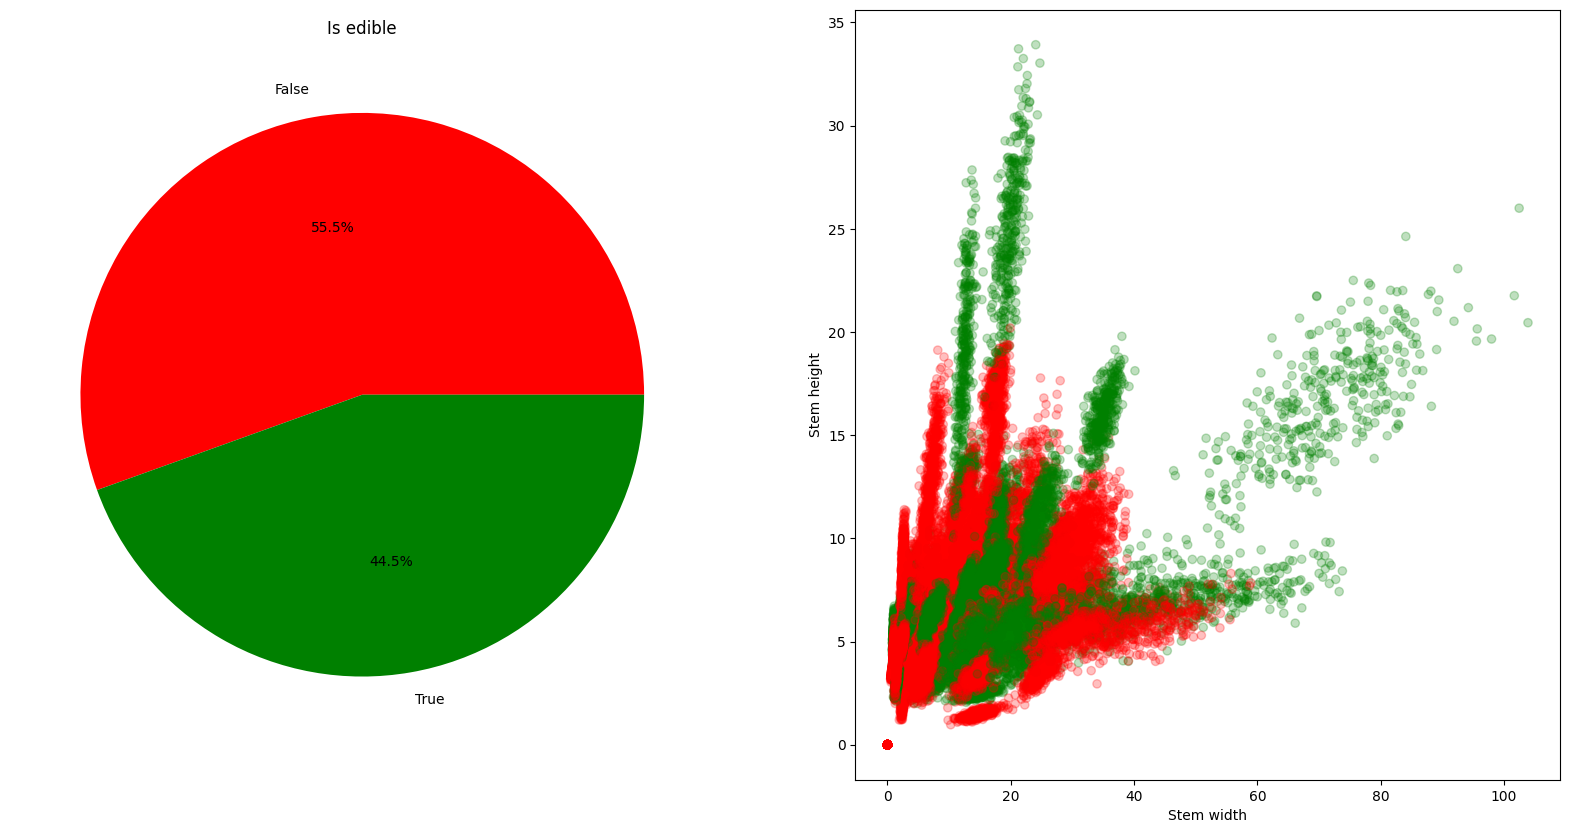

In [393]:
figsize = (20, 10)
is_edible_colors_map = {True: "green", False: "red"}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

mushrooms["is-edible"].value_counts().plot.pie(title="Is edible", colors=[is_edible_colors_map[False], is_edible_colors_map[True]], autopct="%1.1f%%", ylabel="", ax=axes[0])

axes[1].scatter(mushrooms["stem-width"], mushrooms["stem-height"], c=mushrooms["is-edible"].map(is_edible_colors_map), alpha=0.25)
axes[1].set_xlabel("Stem width")
axes[1].set_ylabel("Stem height")

Confrontiamo separatemente l'altezza e la larghezza del gambo con il diametro del cappello.

Notiamo che nel corpo principale dei dati non esiste una netta divisione tra commestibile e non quindi la classificazione non puo essere fatta usando solo quelle 3 feature.

Si osserva anche che se il gambo e' basso o stretto e il cappello e' largo allora il fungo e' spesso commestibile.

Text(0, 0.5, 'Cap diameter')

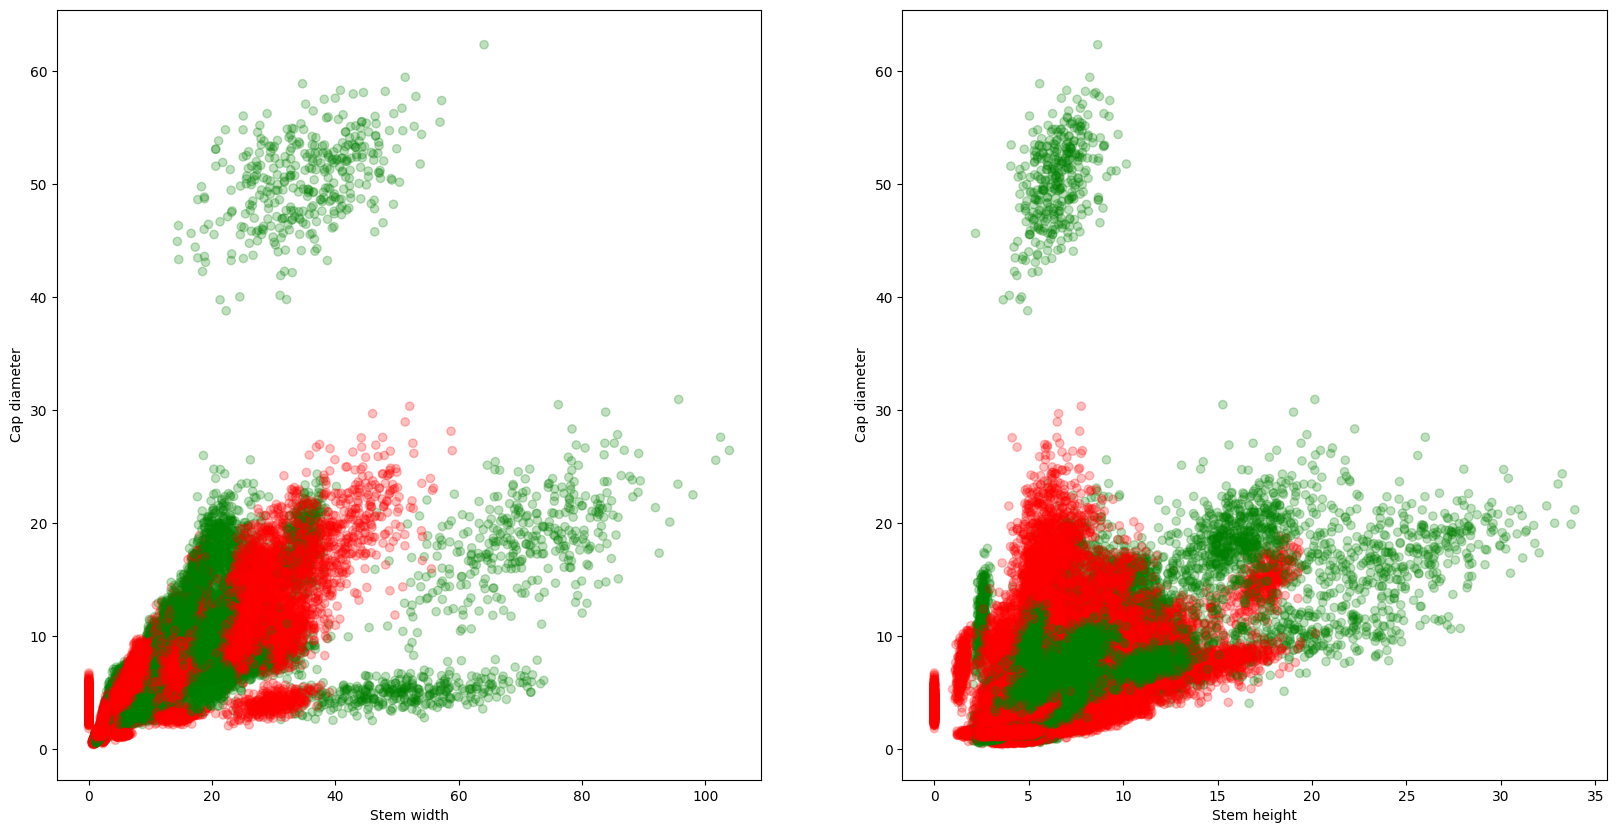

In [394]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

axes[0].scatter(mushrooms["stem-width"], mushrooms["cap-diameter"], c=mushrooms["is-edible"].map(is_edible_colors_map), alpha=0.25)
axes[0].set_xlabel("Stem width")
axes[0].set_ylabel("Cap diameter")

axes[1].scatter(mushrooms["stem-height"], mushrooms["cap-diameter"], c=mushrooms["is-edible"].map(is_edible_colors_map), alpha=0.25)
axes[1].set_xlabel("Stem height")
axes[1].set_ylabel("Cap diameter")

Creiamo una funzione che preso in input una feature da mostrare e le etichette per i valori di quella feature mostri un grafico a barre con il numero di istanze commestibili e non per ogni valore di quella feature.

In [395]:
def plot_feature_against_is_edible_on_hist(feature, feature_values, ax):
    is_not_edible = mushrooms[mushrooms["is-edible"] == False][feature].dropna()
    is_edible = mushrooms[mushrooms["is-edible"] == True][feature].dropna()

    unique_values = pd.Series(mushrooms[feature].unique()).dropna()
    is_not_edible_value_counts = pd.DataFrame(is_not_edible.value_counts())
    is_edible_value_counts = pd.DataFrame(is_edible.value_counts())

    # riempimento con 0 per i valori mancanti della feature
    for unique_value in unique_values:
        if unique_value not in is_not_edible_value_counts.index:
            is_not_edible_value_counts.loc[unique_value] = 0
        if unique_value not in is_edible_value_counts.index:
            is_edible_value_counts.loc[unique_value] = 0

    # ordinamento degli indici
    is_not_edible_value_counts.sort_index(inplace=True)
    is_edible_value_counts.sort_index(inplace=True)

    hist_data = [
        {
            "label": 'Not edible',
            "data": is_not_edible_value_counts["count"],
            "color": is_edible_colors_map[False]
        },
        {
            "label": 'Edible',
            "data": is_edible_value_counts["count"],
            "color": is_edible_colors_map[True]
        }
    ]

    x = np.arange(len(feature_values))
    bars_width = len(feature_values) / figsize[0]

    for i in range(len(hist_data)):
        offset = bars_width * i
        ax.bar_label(ax.bar(x + offset, hist_data[i]["data"], bars_width, label=hist_data[i]["label"], color=hist_data[i]["color"]))

    ax.set_xticks(x + (bars_width / 2), feature_values)
    ax.legend()

La distribuzione dei tipi di inserzioni delle lamelle al gambo e' chiaramente variegata come osservabile dal grafico a torta.

Alcuni tipi di inserzioni delle lamelle, come "adnexed" e "free", tendono ad avere una percentuale maggiore di funghi commestibili nel dataset. Tutti gli altri tipi tendono invece ad avere una percentuale maggiore di funghi non commestibili.

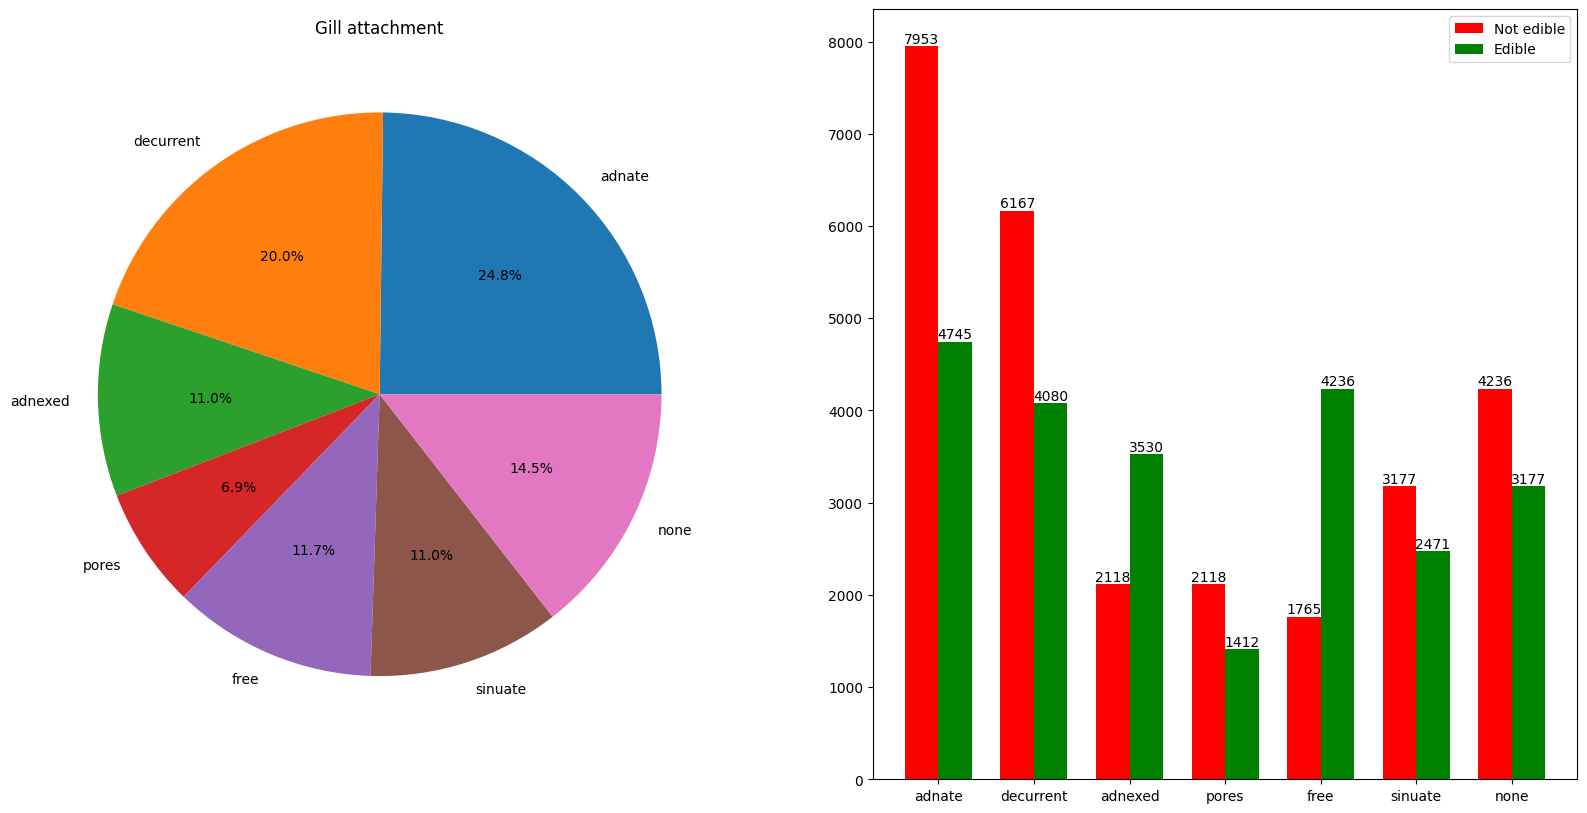

In [396]:
gill_attachment_values = ["adnate", "decurrent", "adnexed", "pores", "free", "sinuate", "none"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

mushrooms["gill-attachment"].value_counts().sort_index().plot.pie(title="Gill attachment", labels=gill_attachment_values, autopct="%1.1f%%", ylabel="", ax=axes[0])

plot_feature_against_is_edible_on_hist("gill-attachment", gill_attachment_values, axes[1])

Si nota che per le stagioni di appartenenza fredde (autunno ed inverno) ci sono meno funghi commestibili che non nel dataset. L'opposto vale per la primavera e l'estate.   

Inoltre meta' dei funghi nel dataset hanno come stagione di appartenza l'autunno. 

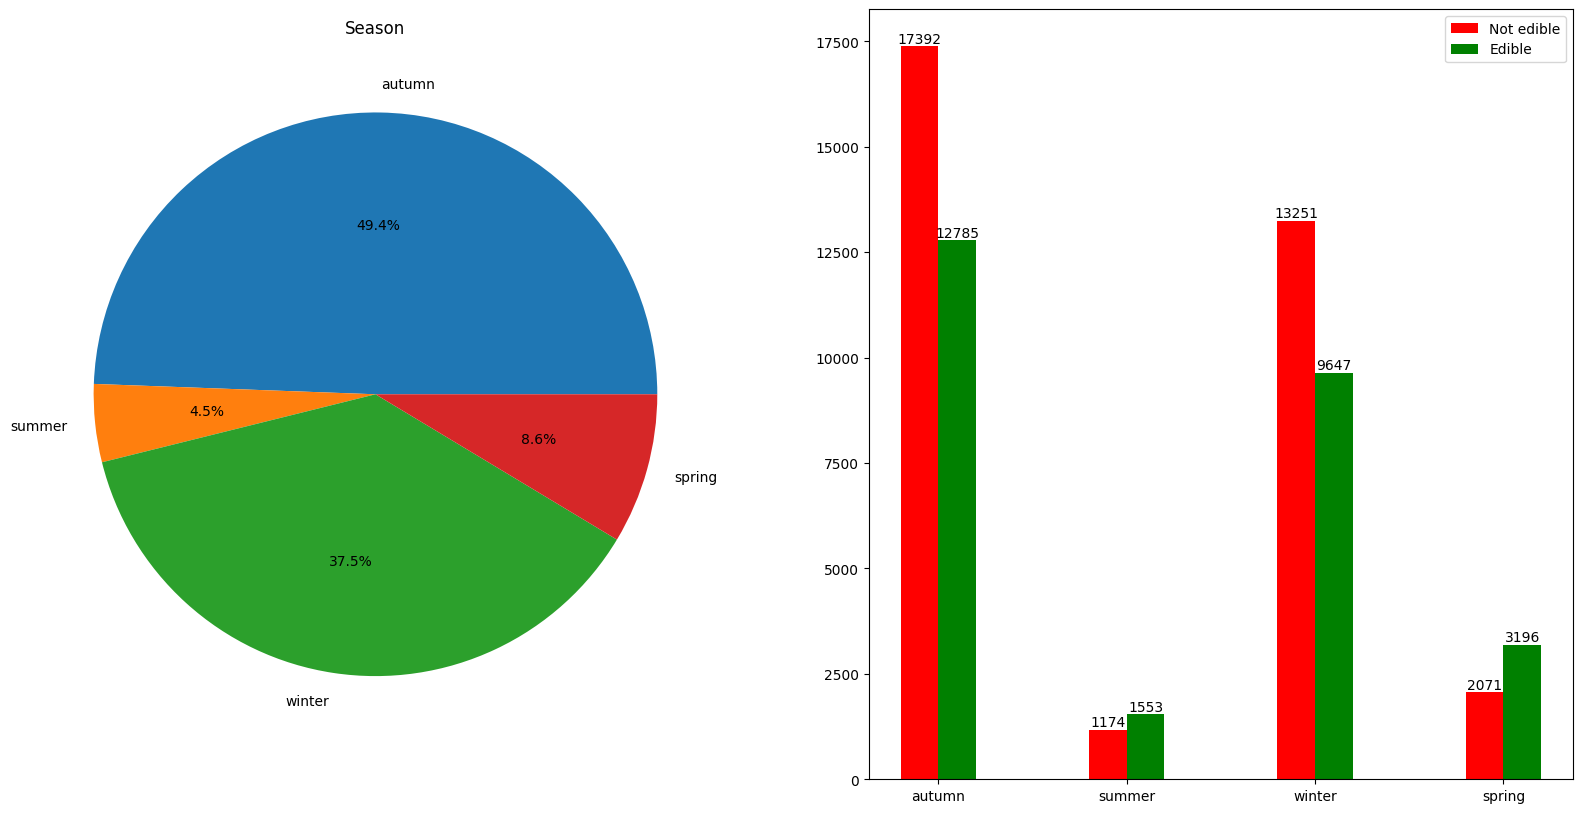

In [397]:
season_values = ["autumn", "summer", "winter", "spring"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

mushrooms["season"].value_counts().sort_index().plot.pie(title="Season", labels=season_values, autopct="%1.1f%%", ylabel="", ax=axes[0])

plot_feature_against_is_edible_on_hist("season", season_values, axes[1])

La maggior parte dei funghi ha il cappello di colore bianco e sono quasi egualmente distribuiti tra commestibili e non. Lo stesso non vale per i funghi con cappelli di altri colori.

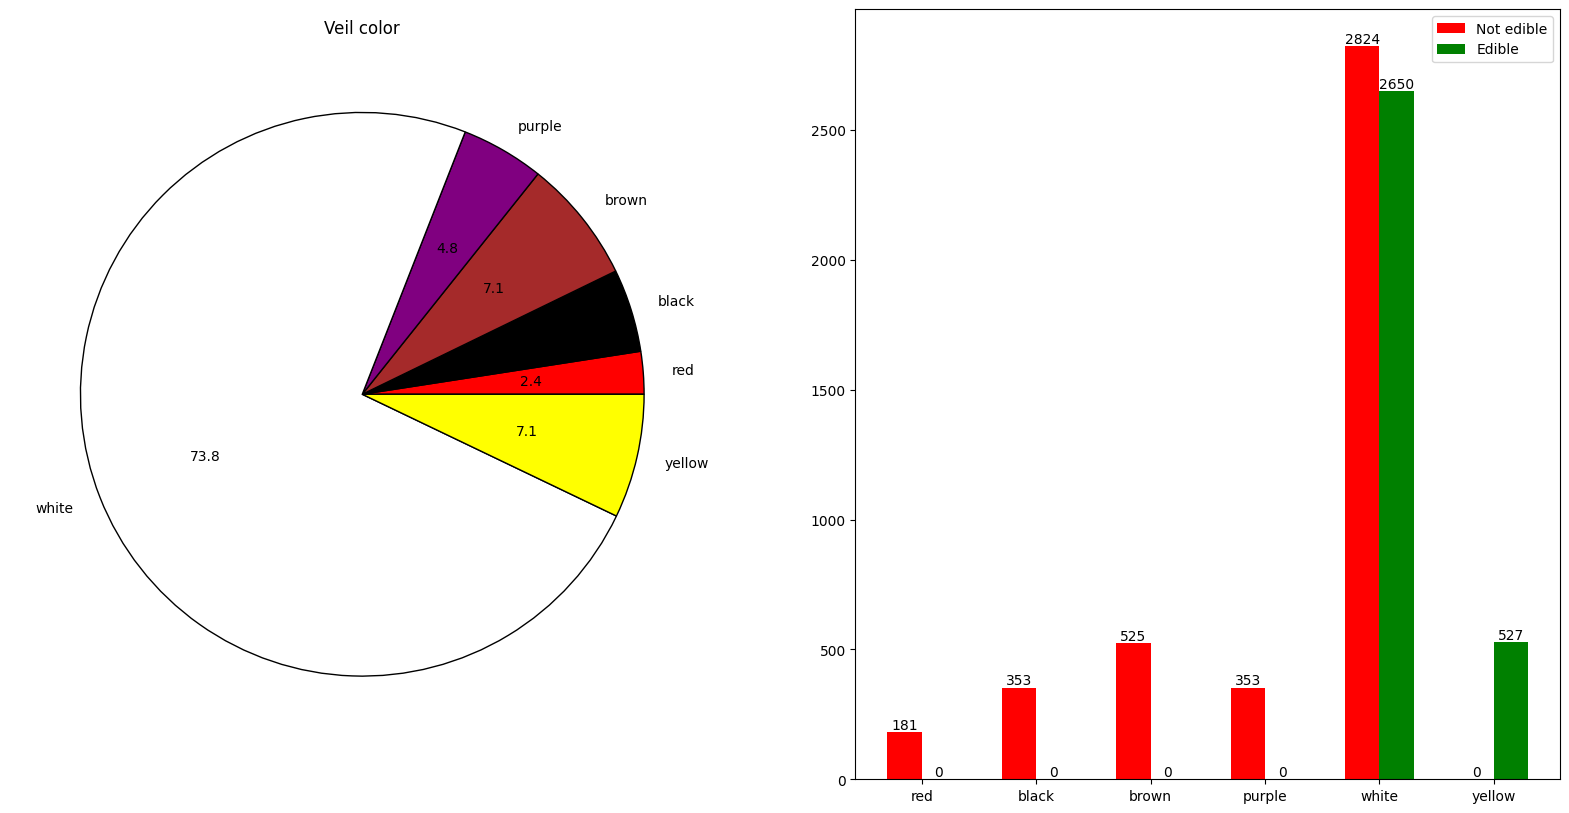

In [398]:
veil_color_values = ["red", "black", "brown", "purple", "white", "yellow" ]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

axes[0].pie(mushrooms["veil-color"].value_counts().sort_index(), labels=veil_color_values, colors=veil_color_values, autopct="%1.1f", wedgeprops={"edgecolor": "black"}, textprops={"color": "black"})
axes[0].set_title("Veil color")

plot_feature_against_is_edible_on_hist("veil-color", veil_color_values, axes[1])

Abbiamo prima notato che la feature `veil-type` ha solo 3177 istanze non nulle su 61069 istanze totali, si osserva inoltre che esiste solo un valore. La feature e' quindi inutile e viene eliminata.

In [399]:
print(mushrooms["veil-type"].value_counts())

mushrooms.drop(columns=["veil-type"], inplace=True)

veil-type
0.0    3177
Name: count, dtype: int64


Si osserva che la stra grande maggioranza dei funghi hanno come habitat i boschi. Quest'ultimi, insieme all'erba e le foglie, rappresentano gli unici habitat non considerati outliers.

La forma del cappello invece non presenta outliers, inoltre il suo intervallo interquartile e' praticamente simmetrico rispetto alla media.

Text(0.5, 1.0, 'Cap Shape Boxplot')

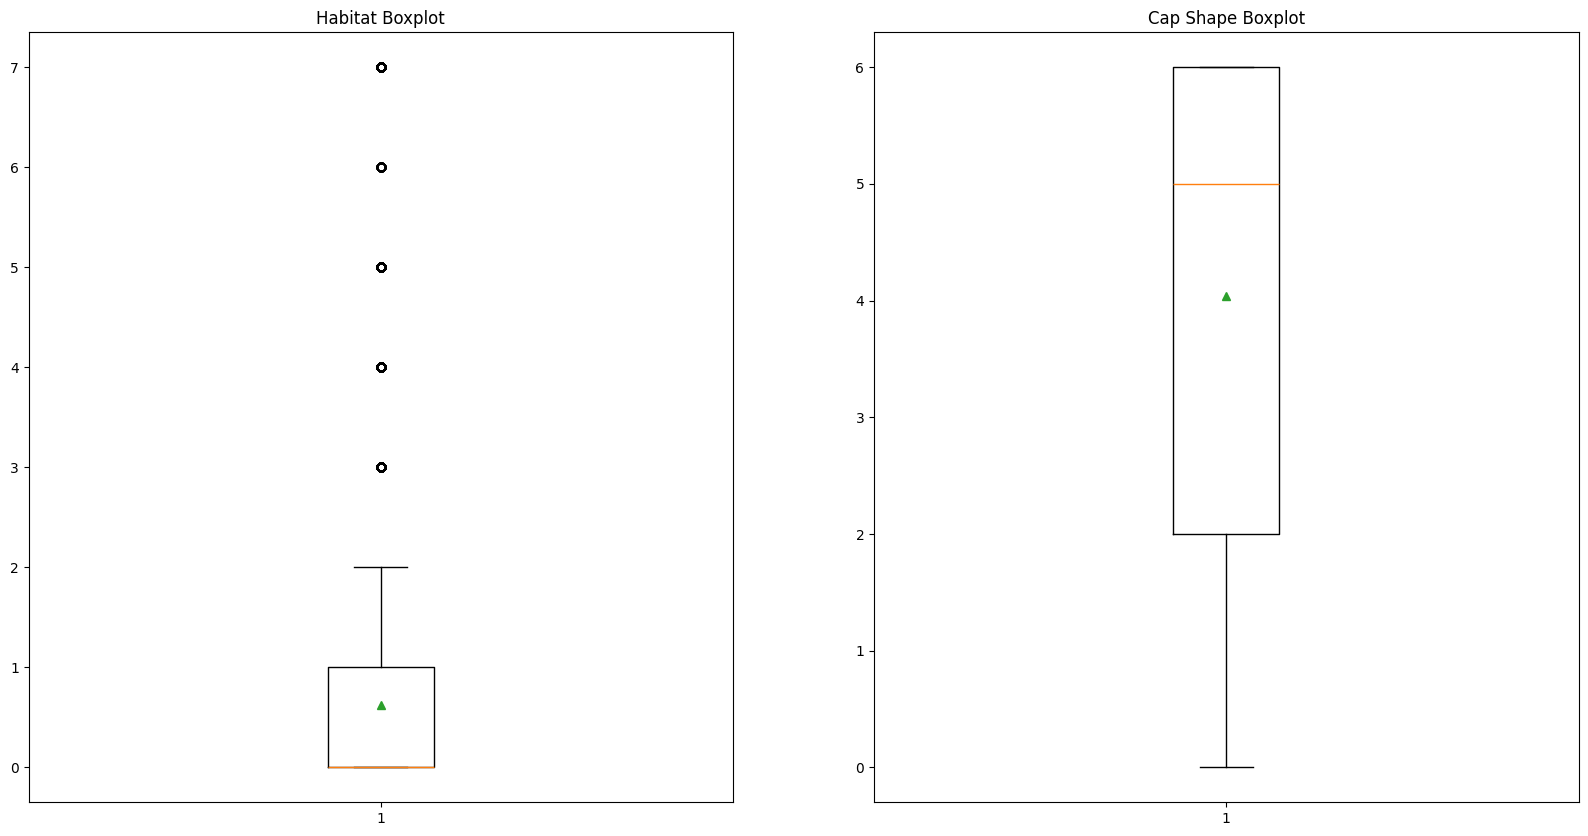

In [400]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

axes[0].boxplot(mushrooms["habitat"], showmeans=True)
axes[0].set_title("Habitat Boxplot")

axes[1].boxplot(mushrooms["cap-shape"], showmeans=True)
axes[1].set_title("Cap Shape Boxplot")

### Riempimento valori nulli
Creiamo una funzione che stampi la percentuale di valori nulli di ogni feature 

In [401]:
def print_na_percentages(df):
    print(df.isna().sum() / df.shape[0] * 100)

print_na_percentages(mushrooms)

is-edible                0.000000
cap-diameter             0.000000
cap-shape                0.000000
cap-surface             23.121387
cap-color                0.000000
does-bruise-or-bleed     0.000000
gill-attachment         16.184971
gill-spacing            41.040462
gill-color               0.000000
stem-height              0.000000
stem-width               0.000000
stem-root               84.393064
stem-surface            62.427746
stem-color               0.000000
veil-color              87.861272
has-ring                 0.000000
ring-type                4.046243
spore-print-color       89.595376
habitat                  0.000000
season                   0.000000
dtype: float64


Calcola tutte le colonne che hanno almeno l'80% di valori nulli ed elimina tutte le righe che hanno valori nulli in tutte quelle colonne

In [402]:
if delete_rows_that_have_columns_with_many_nan:
    columns_with_many_nan = [column for column in mushrooms.columns if mushrooms[column].isna().mean() > 0.80]
    mushrooms.dropna(subset=columns_with_many_nan, how='all', inplace=True)

    print_na_percentages(mushrooms)

is-edible                0.000000
cap-diameter             0.000000
cap-shape                0.000000
cap-surface             23.076923
cap-color                0.000000
does-bruise-or-bleed     0.000000
gill-attachment         23.076923
gill-spacing            51.923077
gill-color               0.000000
stem-height              0.000000
stem-width               0.000000
stem-root               48.076923
stem-surface            61.538462
stem-color               0.000000
veil-color              59.615385
has-ring                 0.000000
ring-type                7.692308
spore-print-color       65.384615
habitat                  0.000000
season                   0.000000
dtype: float64


Riempiamo i valori nulli rimasti con il valore medio. Nel caso in cui si usi KNNImputer i valori saranno calcolati sulla base dei record piu simili possibili che non abbiano un certo valore nullo

In [403]:
columns_to_fill = mushrooms.columns[mushrooms.isna().any()]

imputer = KNNImputer() if use_knn_imputer else SimpleImputer(strategy="mean")
mushrooms[columns_to_fill] = imputer.fit_transform(mushrooms[columns_to_fill])

print_na_percentages(mushrooms)

is-edible               0.0
cap-diameter            0.0
cap-shape               0.0
cap-surface             0.0
cap-color               0.0
does-bruise-or-bleed    0.0
gill-attachment         0.0
gill-spacing            0.0
gill-color              0.0
stem-height             0.0
stem-width              0.0
stem-root               0.0
stem-surface            0.0
stem-color              0.0
veil-color              0.0
has-ring                0.0
ring-type               0.0
spore-print-color       0.0
habitat                 0.0
season                  0.0
dtype: float64


Alla fine di questo processo siamo arrivati ad un dataset di 2.6 MB con 18356 istanze senza nessun valore nullo

In [404]:
mushrooms.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 18356 entries, 0 to 58244
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   is-edible             18356 non-null  bool   
 1   cap-diameter          18356 non-null  float64
 2   cap-shape             18356 non-null  float64
 3   cap-surface           18356 non-null  float64
 4   cap-color             18356 non-null  float64
 5   does-bruise-or-bleed  18356 non-null  bool   
 6   gill-attachment       18356 non-null  float64
 7   gill-spacing          18356 non-null  float64
 8   gill-color            18356 non-null  float64
 9   stem-height           18356 non-null  float64
 10  stem-width            18356 non-null  float64
 11  stem-root             18356 non-null  float64
 12  stem-surface          18356 non-null  float64
 13  stem-color            18356 non-null  float64
 14  veil-color            18356 non-null  float64
 15  has-ring              18

In [405]:
mushrooms.describe()

,cap-diameter,cap-shape,cap-surface,cap-color,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-color,ring-type,spore-print-color,habitat,season
count,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000
mean,7.491805,4.197919,5.548088,5.597352,2.901133,0.400000,7.500054,8.066530,13.301566,2.074074,4.007790,8.425528,3.641306,2.048277,2.656437,0.544236,1.074036
std,4.258446,2.157740,2.616393,2.995930,1.836552,0.480398,3.047370,4.310421,9.738472,1.223615,1.501122,3.231006,0.664270,1.969178,1.137868,1.070520,1.118683
min,0.440000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.040000,2.000000,4.000000,5.000000,2.000000,0.000000,5.000000,5.540000,6.660000,2.000000,4.007790,6.000000,3.641306,1.000000,2.656437,0.000000,0.000000
50%,6.970000,6.000000,5.548088,5.000000,2.901133,0.400000,10.000000,7.600000,12.340000,2.074074,4.007790,11.000000,3.641306,1.000000,2.656437,0.000000,1.000000
75%,9.500000,6.000000,7.000000,8.000000,4.000000,0.400000,10.000000,10.040000,17.760000,2.305556,4.007790,11.000000,4.000000,2.048277,2.656437,1.000000,2.000000
max,25.980000,6.000000,10.000000,11.000000,6.000000,2.000000,11.000000,33.920000,73.800000,4.000000,7.000000,12.000000,5.000000,7.000000,6.000000,4.000000,3.000000


### Ulteriori miglioramenti
Verifichiamo per ogni colonna che non ci siano piu' di 99% di valori uguali, percio' non siano irrelevanti

In [406]:
sel = VarianceThreshold(threshold=0.01)
sel.fit(mushrooms)

[column for column in mushrooms.columns if column not in sel.get_feature_names_out()]

[]

Effettuiamo la normalizzazione dei dati con norma l2 per ...

In [407]:
if normalize_data:
    float_columns = mushrooms.select_dtypes(include="float64").columns

    normalizer = Normalizer(norm="l2")
    mushrooms[float_columns] = normalizer.fit_transform(mushrooms[float_columns])

    mushrooms.describe()

## Selezione delle feature
Dividiamo feature e variabile di classe

In [408]:
y = mushrooms["is-edible"]
X_all = mushrooms.drop(columns="is-edible")

Se necessario si selezionano le k migliori feature usando `SelectKBest`, ...

In [409]:
if k_best_features_to_select > 0:
    selector = SelectKBest(k=k_best_features_to_select)
    best_features = selector.fit_transform(X_all, y)

    X = pd.DataFrame(best_features, columns=selector.get_feature_names_out())
else:
    X = X_all

Standardizzazione dei dati

In [410]:
if standardize_data:
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X[X.columns])

    X.describe()

## Sviluppo di un modello
### Suddivisione dei dati
Si divide il dataset in due porzioni: 2/3 dei dati per l'addestramento dei modelli (`_train`) e 1/3 dei dati per test (`_test`). La porzione di dati per test viene poi suddivisa in altre due porzioni: 2/3 per la validazione dei modelli (`_val`) e 1/3 per la verifica finale dell'overfitting del modello (`_overfit`).

I dati iniziali sono stati quindi suddivisi cosi:
- 6/9 per l'addestramento
- 2/9 per validazione
- 1/9 per test dell'overfitting

In questo modo i dati usati per fare il test dell'overfitting sono completamente esclusi dalla fase di addestramento e miglioramento del modello.

In [411]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=1/3,
    random_state=42
)

X_val, X_overfit, y_val, y_overfit = train_test_split(
    X_test, y_test,
    test_size=1/3,
    random_state=42
)

Si prepara la KFold Cross Validation usata per migliorare l'affidabilita' 

In [412]:
skf = StratifiedKFold(3, shuffle=True, random_state=42)

### Scelta del modello

Creiamo una funzione che valuti un modello e ne riporti lo Score, la Precision, il Recall e l'F1-Score. Inoltre mostri anche la matrice di confusione utile per visualizzare il numero di falsi negativi o positivi

In [413]:
def print_eval(X, y, model):
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy/Score: {accuracy:.5}")

    print("Classification report")
    print(classification_report(y, y_pred))

    cm = confusion_matrix(y, y_pred, labels=model.classes_)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()

Creiamo una funzione che presi i dati di allenamento, un modello e una grid di parametri per il modello esegue Grid Search CV

In [414]:
def grid_search_fit_and_print(X_train, y_train, model, grid):
    grid_search = GridSearchCV(model, grid, cv=skf, scoring="accuracy")
    grid_search.fit(X_train, y_train)

    display(pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score").head(5))

    return grid_search

#### Logistic Regression
solver saga

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__fit_intercept,param_lr__penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,0.218955,0.002261,0.006080,0.000769,False,l1,"{'lr__fit_intercept': False, 'lr__penalty': 'l1'}",0.806570,0.800196,0.794312,0.800360,0.005006,1
3,0.404884,0.080366,0.005662,0.000711,True,l1,"{'lr__fit_intercept': True, 'lr__penalty': 'l1'}",0.799461,0.787938,0.784261,0.790553,0.006475,2
2,0.069518,0.003271,0.006409,0.001150,True,l2,"{'lr__fit_intercept': True, 'lr__penalty': 'l2'}",0.791125,0.778622,0.778867,0.782872,0.005837,3
0,0.055883,0.000970,0.005346,0.000845,False,l2,"{'lr__fit_intercept': False, 'lr__penalty': 'l2'}",0.784751,0.775435,0.773964,0.778050,0.004776,4


Accuracy/Score: 0.80142
Classification report
              precision    recall  f1-score   support

       False       0.84      0.86      0.85      2635
        True       0.73      0.70      0.71      1444

    accuracy                           0.80      4079
   macro avg       0.78      0.78      0.78      4079
weighted avg       0.80      0.80      0.80      4079



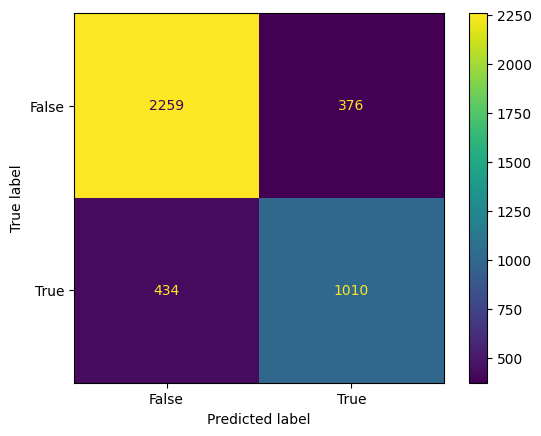

In [415]:
logreg_model = Pipeline([("lr", LogisticRegression(solver="saga", random_state=42))])
logreg_grid = {
    "lr__penalty": ["l2", "l1"],
    "lr__fit_intercept": [False, True]
}

logreg_grid_search = grid_search_fit_and_print(X_train, y_train, logreg_model, logreg_grid)
print_eval(X_val, y_val, logreg_grid_search)

#### Decision Tree

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dtc__criterion,param_dtc__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.075141,0.005848,0.006079,0.000930,gini,2,"{'dtc__criterion': 'gini', 'dtc__min_samples_s...",0.799215,0.801912,0.79799,0.799706,0.001638,1
1,0.078249,0.006662,0.007160,0.000292,gini,3,"{'dtc__criterion': 'gini', 'dtc__min_samples_s...",0.799215,0.801912,0.79799,0.799706,0.001638,1
2,0.083620,0.015530,0.005192,0.000088,gini,4,"{'dtc__criterion': 'gini', 'dtc__min_samples_s...",0.799215,0.801912,0.79799,0.799706,0.001638,1
3,0.092039,0.006181,0.004764,0.000066,entropy,2,"{'dtc__criterion': 'entropy', 'dtc__min_sample...",0.726649,0.773719,0.72150,0.740623,0.023497,4
4,0.146884,0.044439,0.010195,0.003899,entropy,3,"{'dtc__criterion': 'entropy', 'dtc__min_sample...",0.726649,0.773719,0.72150,0.740623,0.023497,4


Accuracy/Score: 0.79309
Classification report
              precision    recall  f1-score   support

       False       0.95      0.72      0.82      2635
        True       0.64      0.93      0.76      1444

    accuracy                           0.79      4079
   macro avg       0.80      0.82      0.79      4079
weighted avg       0.84      0.79      0.80      4079



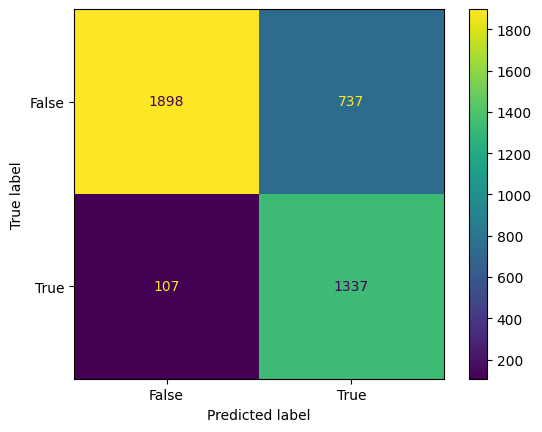

In [416]:
tree_model = Pipeline([("dtc", DecisionTreeClassifier(max_depth=3, random_state=42))])
tree_grid = {
    'dtc__criterion': ['gini', 'entropy'],
    'dtc__min_samples_split': range(2, 5),
}

tree_grid_search = grid_search_fit_and_print(X_train, y_train, tree_model, tree_grid)
print_eval(X_val, y_val, tree_grid_search)

#### Random forest

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__criterion,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,3.125787,0.017472,0.042629,0.000459,entropy,110,"{'rf__criterion': 'entropy', 'rf__n_estimators...",1.000000,1.0,1.0,1.000000,0.000000,1
6,2.864559,0.017724,0.039475,0.000863,entropy,100,"{'rf__criterion': 'entropy', 'rf__n_estimators...",1.000000,1.0,1.0,1.000000,0.000000,1
5,2.715073,0.019047,0.036851,0.001639,entropy,90,"{'rf__criterion': 'entropy', 'rf__n_estimators...",1.000000,1.0,1.0,1.000000,0.000000,1
4,2.517653,0.025448,0.035297,0.001017,entropy,80,"{'rf__criterion': 'entropy', 'rf__n_estimators...",1.000000,1.0,1.0,1.000000,0.000000,1
3,2.759899,0.010587,0.048092,0.001034,gini,110,"{'rf__criterion': 'gini', 'rf__n_estimators': ...",0.999755,1.0,1.0,0.999918,0.000116,5


Accuracy/Score: 1.0
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2635
        True       1.00      1.00      1.00      1444

    accuracy                           1.00      4079
   macro avg       1.00      1.00      1.00      4079
weighted avg       1.00      1.00      1.00      4079



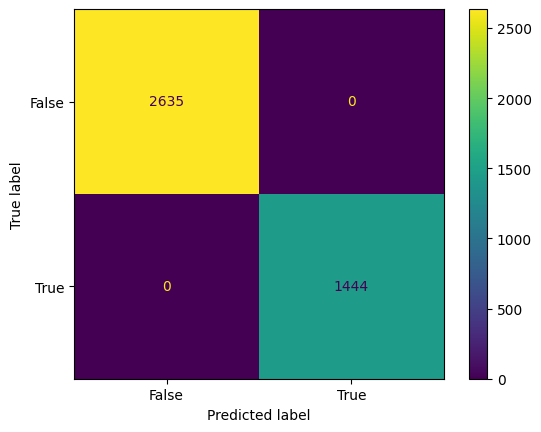

In [417]:
random_forest_model = Pipeline([("rf", RandomForestClassifier(random_state=42))])
random_forest_grid = {
    'rf__criterion': ['gini', 'entropy'],
    'rf__n_estimators': range(80, 120, 10),
}

random_forest_grid_search = grid_search_fit_and_print(X_train, y_train, random_forest_model, random_forest_grid)
print_eval(X_val, y_val, random_forest_grid_search)

#### KNN Classifier

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008380,0.000682,0.439282,0.057179,3,uniform,"{'knn__n_neighbors': 3, 'knn__weights': 'unifo...",1.00000,1.0,1.0,1.000000,0.000000,1
1,0.008493,0.000733,0.072668,0.000519,3,distance,"{'knn__n_neighbors': 3, 'knn__weights': 'dista...",1.00000,1.0,1.0,1.000000,0.000000,1
2,0.007821,0.000904,0.397455,0.003872,4,uniform,"{'knn__n_neighbors': 4, 'knn__weights': 'unifo...",1.00000,1.0,1.0,1.000000,0.000000,1
3,0.007921,0.000858,0.073026,0.001106,4,distance,"{'knn__n_neighbors': 4, 'knn__weights': 'dista...",1.00000,1.0,1.0,1.000000,0.000000,1
4,0.008004,0.000540,0.396436,0.003636,5,uniform,"{'knn__n_neighbors': 5, 'knn__weights': 'unifo...",0.99951,1.0,1.0,0.999837,0.000231,5


Accuracy/Score: 1.0
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2635
        True       1.00      1.00      1.00      1444

    accuracy                           1.00      4079
   macro avg       1.00      1.00      1.00      4079
weighted avg       1.00      1.00      1.00      4079



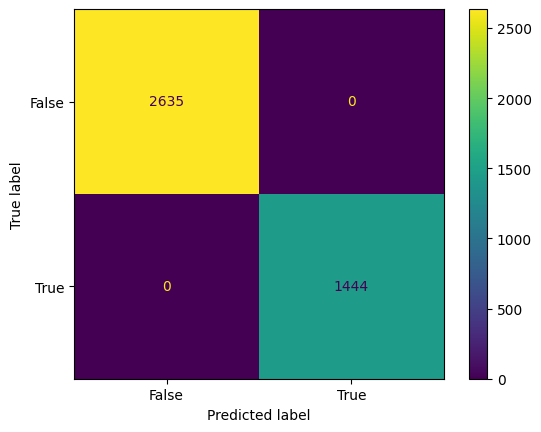

In [418]:
knn_model = Pipeline([("knn", KNeighborsClassifier())])
knn_grid = {
    'knn__n_neighbors': range(3, 7),
    'knn__weights': ['uniform', 'distance']
}

knn_grid_search = grid_search_fit_and_print(X_train, y_train, knn_model, knn_grid)
print_eval(X_val, y_val, knn_grid_search)

### Valutazione finale dei modelli
Si osserva come un modello completamente casuale ha uno score di 0.65, molto piu' basso di quello ottenuto dai migliori modelli trovati precedentemente.

Accuracy/Score: 0.64599
Classification report
              precision    recall  f1-score   support

       False       0.65      1.00      0.78      2635
        True       0.00      0.00      0.00      1444

    accuracy                           0.65      4079
   macro avg       0.32      0.50      0.39      4079
weighted avg       0.42      0.65      0.51      4079



/Users/mauropellonara/Documents/mushrooms-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mauropellonara/Documents/mushrooms-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mauropellonara/Documents/mushrooms-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

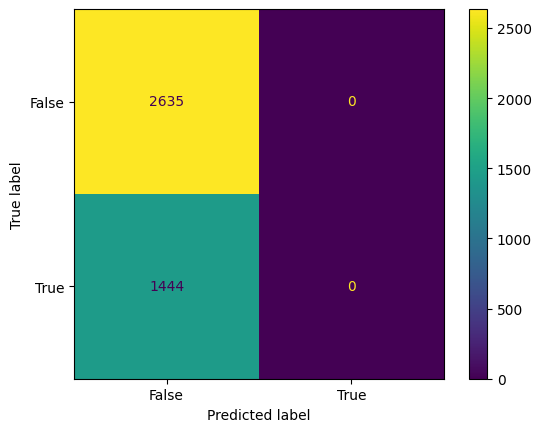

In [419]:
dummy_model = DummyClassifier(random_state=42)
dummy_model.fit(X_train, y_train)

print_eval(X_val, y_val, dummy_model)

Si visualizza la precision recall curve dei 4 modelli usati

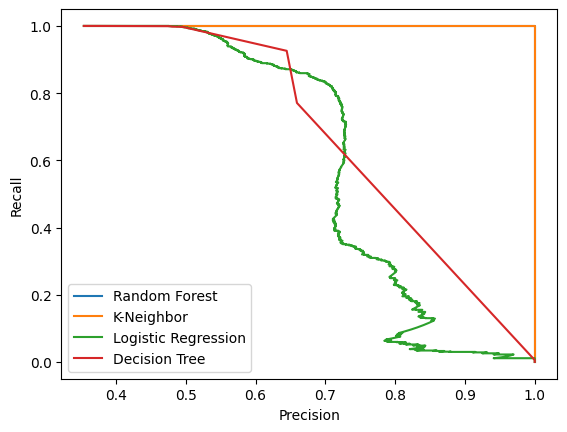

In [420]:
precision_rf, recall_rf, _ = precision_recall_curve(y_val, random_forest_grid_search.predict_proba(X_val)[:, 1])
precision_knn, recall_knn, _ = precision_recall_curve(y_val, knn_grid_search.predict_proba(X_val)[:, 1])
precision_logreg, recall_logreg, _ = precision_recall_curve(y_val, logreg_grid_search.predict_proba(X_val)[:, 1])
precision_tree, recall_tree, _ = precision_recall_curve(y_val, tree_grid_search.predict_proba(X_val)[:, 1])

plt.plot(precision_rf, recall_rf, label="Random Forest")
plt.plot(precision_knn, recall_knn, label="K-Neighbor")
plt.plot(precision_logreg, recall_logreg, label="Logistic Regression")
plt.plot(precision_tree, recall_tree, label="Decision Tree")

plt.xlabel("Precision")
plt.ylabel("Recall")

plt.legend(loc="lower left")

Si verifica ora l'overfitting dei due modelli migliori: il Random Forest e il K-Neighbours

Accuracy/Score: 1.0
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1298
        True       1.00      1.00      1.00       742

    accuracy                           1.00      2040
   macro avg       1.00      1.00      1.00      2040
weighted avg       1.00      1.00      1.00      2040



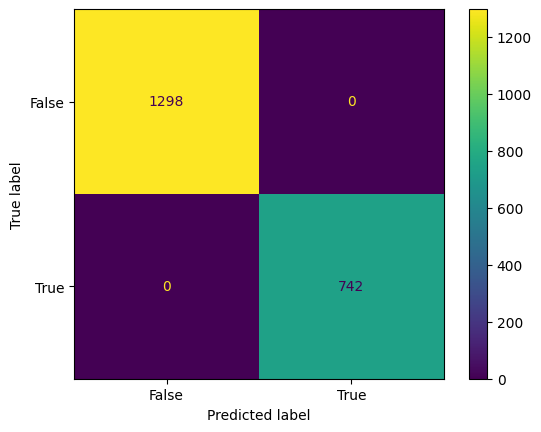

In [421]:
print_eval(X_overfit, y_overfit, random_forest_grid_search)

Accuracy/Score: 1.0
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1298
        True       1.00      1.00      1.00       742

    accuracy                           1.00      2040
   macro avg       1.00      1.00      1.00      2040
weighted avg       1.00      1.00      1.00      2040



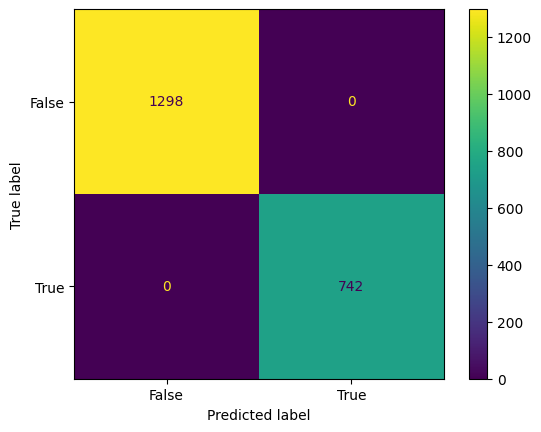

In [422]:
print_eval(X_overfit, y_overfit, knn_grid_search)

## Conclusioni finali
If you don't normalize the data and you keep 7+ features than you will still get to 100% accuracy
But if you want to lower the amount of features to below 5 than normalizing data improves the accuracy quite a bit

It's also nice to reduce the number of selected features as it makes the real life application more reasonable

Removing all those rows with NaN values in those 4 columns improves the quality of data a lot, and we still come out with 18k rows of valuable data. Less data filling -> better quality of data -> faster training